<a href="https://colab.research.google.com/github/prathmesh0203/simulation/blob/master/simulaiton_multi_objective_solar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install pulp


In [35]:

import numpy as np
import pulp as lp
import re
from matplotlib import pyplot as plt
from queue import PriorityQueue
import pandas as pd

def user_definedProb(Charge_Freq,values):
    totalFreq = sum(Charge_Freq)
    Charge_Prob = [x / totalFreq for x in Charge_Freq]
    Charge_Prob_new = np.zeros(1440)
    values_interval = np.int_([x * 60 for x in values])
    j = 0
    for j in range(16):
        if j < 15:
            index_bottom = values_interval[j]
            index_upper = values_interval[j + 1]
            Charge_Prob_new[index_bottom:index_upper] = Charge_Prob[j]
        if j == 15:
            index_bottom = values_interval[0]
            Charge_Prob_new[0:index_bottom] = Charge_Prob[j]
            index_upper = values_interval[j]
            if index_upper < 1440:
                Charge_Prob_new[index_upper:1440] = Charge_Prob[j]
    totalFreq = sum(Charge_Prob_new)
    Charge_Prob_new2 = [x / totalFreq for x in Charge_Prob_new]
    return Charge_Prob_new2

def getArrivalTime(nVech): # starting time is defined by use cases
    if useCase ==1: #residential
        arrivalTime = np.random.normal(20, 2, nVech)
        return arrivalTime
    if useCase==2:  #office
        arrivalTime = np.random.lognormal(2.32274, 0.301833, nVech)
        return arrivalTime
    if useCase==3: #commercial
        Charge_Freq = [507.377049200000, 422.885245900000, 401.639344300000, 420.262295100000, 508.688524600000,
                        634.918032800000, 898.52459000000, 1390.57377000000, 1913.80327900000, 2187.81967200000,
                        2363.32786900000, 2139.70491800000, 1821.21511500000, 1335.36065600000, 1311.39344300000,
                        603.377049180328]
        values = [0.097654718, 1.146678171, 3.221429132, 5.887402934, 7.3409287, 9.046121264, 10.92744529, 13.06608361,
                   15.9770178100000, 18.0320025100000, 19.7054278800000, 21.7332339800000, 22.5238842300000,
                   23.1479331700000, 23.8559887000000, 24.0976547180171]
        values_new = range(1440)
        Charge_Prob_new2=user_definedProb(Charge_Freq,values)
        arrivalTime = np.random.choice(values_new, nVech, p=list(Charge_Prob_new2))
        return arrivalTime/60
    if useCase==4: #public
        Charge_Freq = [377.049180300000, 407.065573800000, 439.491803300000, 502.68852500000,
                       557.18032800000, 664.37704900000, 874.91803300000, 1109.42623000000, 1773.93442600000,
                       1974.59016400000, 2073.77049200000, 2098.36065600000, 2110.65573800000, 2116.80327900000,
                       2104.50819700000, 2086.06557400000, 2079.91803300000, 2055.32786900000, 1944.67213100000,
                       1840.16393400000, 1704.91803300000, 1606.55737700000, 1508.19672100000, 1348.36065600000,
                       1225.40983600000, 1108.60655700000, 979.508196700000, 881.147541000000, 367.131147500000]
        values = [0.466860146000000, 0.971605616000000, 1.90838497100000, 2.84092870000000,
                  3.94501529500000, 4.96368342600000, 5.81645619300000, 6.58557533900000, 7.35469448600000,
                  8.64020707500000, 9.84312495100000, 11.8225743200000, 13.3721076200000, 14.9219938800000,
                  16.4729390500000, 18.1103616000000, 19.7040160000000, 21.3417915100000, 22.2955133700000,
                  22.7321358500000, 22.8690877700000, 22.9608596800000, 23.0956937800000, 23.2340575700000,
                  23.3272413500000, 23.3770099600000, 23.5136089100000, 23.5623186100000, 23.7035061600000]
        values_new=range (1440)
        Charge_Prob_new2=user_definedProb(Charge_Freq, values)
        arrivalTime = np.random.choice(values_new, nVech, p=list(Charge_Prob_new2))
        return arrivalTime/60

def time24(time):
    condlist = [time< 2160, time >=2160]
    choicelist= [time, -1]
    time=np.select(condlist, choicelist)

    condlist = [time < 1440, time >= 1440]
    choicelist = [time, time - 1440]
    time = np.select(condlist, choicelist)
    return time

def getStartingSOC(isSlow): # SOC is defined by charging frequencies
    if isSlow == 1: # slow charge: one charge per day
        dist_list = np.random.lognormal(3.67017251945698, 0.532230403897875, n_slowVeh)
        startingSOC = 1 - dist_list / batteryRange
        return startingSOC

    if isSlow > 1: # fast charge: multiple days per charge
        if useCase==1 or useCase==2: # resiential & office: 'mileages traveled' approach
            dist_list = np.random.lognormal(3.67017251945698, 0.532230403897875, n_fastVeh)
            for i in range(n_fastVeh):
                dist_list[i] = dist_list[i] * Charge_frequency
                if dist_list[i] > batteryRange * 0.8:  #cannot be below 20%SOC
                    while True:
                        dist_list[i] = np.random.lognormal(3.67017251945698, 0.532230403897875, 1)
                        dist_list[i] = dist_list[i] * Charge_frequency
                        if dist_list[i] <= batteryRange * 0.8:
                            break
            startingSOC = 1 - dist_list / batteryRange
            return startingSOC
        if useCase>2: # commercial & public: 'predefined starting SOC':
            startingSOC = np.random.beta(1.37722, 3.42153, n_fastVeh)
            return startingSOC


def getStartingSOC_V2G(n_Veh):  # SOC is defined by charging frequencies
    if useCase == 1 or useCase == 2:  # resiential & office: 'mileages traveled' approach
        dist_list = np.random.lognormal(3.67017251945698, 0.532230403897875, n_Veh)
        for i in range(n_Veh):
            dist_list[i] = dist_list[i] * Charge_frequency
            if dist_list[i] > batteryRange * 0.8:  # cannot be below 20%SOC
                while True:
                    dist_list[i] = np.random.lognormal(3.67017251945698, 0.532230403897875, 1)
                    dist_list[i] = dist_list[i] * Charge_frequency
                    if dist_list[i] <= batteryRange * 0.8:
                        break
        startingSOC = 1 - dist_list / batteryRange
        return startingSOC
    if useCase > 2:  # commercial & public: 'predefined starting SOC':
        startingSOC = np.random.beta(1.37722, 3.42153, n_Veh)
        return startingSOC

In [36]:
def Unmanaged_charge():
    iterator=range(n_iter)
    endSOC=1

    #first distinguish vehicles that use slow charge from those that use fast charge
    if n_slowVeh >0:
        slow_Load_maxtrix = np.zeros((n_iter, Maxtime_Interval))

        for it in iterator:
            slow_Load=np.zeros(Maxtime_Interval)

            startingSOC=getStartingSOC(1)
            charge_Duration=(endSOC-startingSOC) * batteryCapacity/power_Slow/charge_efficiency*60

            arrivalTime = getArrivalTime(n_slowVeh)
            arrivalTime.sort()
            arrivalTime = np.int_(np.round(arrivalTime * 60))

            # calculate the charging starting time based on the queuing size, that is, limited number of chargers
            startingTime = np.zeros(n_slowVeh)
            endTime = np.zeros(n_slowVeh)
            startingTime[:nslow_Chargers] = arrivalTime[:nslow_Chargers]
            endTime[:nslow_Chargers] = np.int_(
                np.around(startingTime[:nslow_Chargers] + charge_Duration[:nslow_Chargers]))

            q = PriorityQueue()
            for i in range(0, nslow_Chargers):  # initiate the queue
                q.put(endTime[i])
            for i in range(nslow_Chargers, len(arrivalTime)):
                non_available = [j for j in q.queue if j > arrivalTime[i]]
                # print('que status', q.queue)
                if len(non_available) == nslow_Chargers:
                    startingTime[i] = np.int_(min(non_available)) + 1
                    q.get()
                else:
                    startingTime[i] = np.int_(arrivalTime[i])
                    q.get()
                endTime[i] = np.int_(np.around(startingTime[i] + charge_Duration[i]))
                q.put(endTime[i])

            waitTime = startingTime - arrivalTime
            startingTime = time24(startingTime)
            endTime = time24(endTime)
            startingTime = [int(i) for i in startingTime]
            endTime = [int(i) for i in endTime]
            for i in range(0, len(waitTime)):
                if endTime[i] == -1:
                    waitTime[i] = 0
            avgwaitSlow = np.mean(waitTime)
            unChargedveh_slow = endTime.count(-1)
            # print('arrival time', arrivalTime)
            # print('starting time', startingTime)
            # print('end time', endTime)
            # print('wait time', waitTime)
            # print('average wait time for slow chargers is %5.2f hours' %avgwaitSlow)
            # print('%4d vehicles uncharged due to lack of slow chargers' %unChargedveh_slow)


            for c in range(n_slowVeh):
                if endTime[c] ==-1 or startingTime[c] ==-1:
                    break
                if endTime[c]<=Maxtime_Interval:
                    iterator_time=np.arange(startingTime[c]-1,endTime[c],1)
                    for t in iterator_time:
                        slow_Load[t]= slow_Load[t]+power_Slow
                if endTime[c]>Maxtime_Interval:
                    iterator_time=np.arange(startingTime[c]-1, Maxtime_Interval,1)
                    for t in iterator_time:
                        slow_Load[t]=slow_Load[t]+power_Slow
                    iterator_time=np.arange(0,endTime[c]-Maxtime_Interval,1)
                    for t in iterator_time:
                        slow_Load[t]=slow_Load[t]+power_Slow
            slow_Load_maxtrix[it]=slow_Load

        slow_Load_avg=slow_Load_maxtrix.mean(0)
        slow_Load_var=slow_Load_maxtrix.std(0)
        slow_Load_upper=slow_Load_avg+slow_Load_var*2
        slow_Load_bottom=slow_Load_avg-slow_Load_var*2

        iterator_time=range(24)
        for t in iterator_time:
            slow_Load_1h_avg[t]=np.average(slow_Load_avg[t*60:(t+1)*60])
        slow_Load_1h_upper=np.zeros(24)
        for t in iterator_time:
            slow_Load_1h_upper[t]=np.average(slow_Load_upper[t*60:(t+1)*60])
        slow_Load_1h_bottom=np.zeros(24)
        for t in iterator_time:
            slow_Load_1h_bottom[t]=np.average(slow_Load_bottom[t*60:(t+1)*60])

    if n_fastVeh >0:
        fast_Load_matrix = np.zeros((n_iter, Maxtime_Interval))

        for it in iterator:
            fast_Load=np.zeros(Maxtime_Interval)

            startingSOC=getStartingSOC(2)
            charge_Duration=(endSOC-startingSOC) * batteryCapacity/power_Fast/charge_efficiency*60

            arrivalTime = getArrivalTime(n_fastVeh)
            arrivalTime.sort()
            arrivalTime = np.int_(np.round(arrivalTime * 60))

            # calculate the charging starting time based on the queuing situation, that is, limited number of chargers
            startingTime = np.zeros(n_fastVeh)
            endTime = np.zeros(n_fastVeh)
            startingTime[:nfast_Chargers] = arrivalTime[:nfast_Chargers]
            endTime[:nfast_Chargers] = np.int_(
                np.around(startingTime[:nfast_Chargers] + charge_Duration[:nfast_Chargers]))

            q = PriorityQueue()
            for i in range(0, nfast_Chargers):  # initiate the queue
                q.put(endTime[i])
            for i in range(nfast_Chargers, len(arrivalTime)):
                non_available = [j for j in q.queue if j > arrivalTime[i]]
                #print('que status', q.queue)
                if len(non_available) == nfast_Chargers:
                    startingTime[i] = np.int_(min(non_available)) + 1
                    q.get()
                else:
                    startingTime[i] = np.int_(arrivalTime[i])
                    q.get()
                endTime[i] = np.int_(np.around(startingTime[i] + charge_Duration[i]))
                q.put(endTime[i])

            # print('starting time before 24hours', startingTime)
            # print('end time before 24hours', endTime)
            waitTime = (startingTime - arrivalTime) / 60
            startingTime = time24(startingTime)
            endTime = time24(endTime)
            startingTime = [int(i) for i in startingTime]
            endTime = [int(i) for i in endTime]
            for i in range(0, len(waitTime)):
                if endTime[i] == -1:
                    waitTime[i] = 0
            avgwaitfast = np.mean(waitTime)
            unChargedveh_fast = endTime.count(-1)
            # print('arrival time', arrivalTime)
            # print('starting time', startingTime)
            # print('end time', endTime)
            # print('average wait time for fast chargers is %5.2f hours' %avgwaitfast)
            # print('%4d vehicles uncharged due to lack of fast chargers' %unChargedveh_fast)

            for c in range(n_fastVeh):
                if endTime[c] ==-1 or startingTime[c] ==-1:
                    break
                if endTime[c]>startingTime[c]:
                    iterator_time=np.arange(startingTime[c]-1,endTime[c],1)
                    for t in iterator_time:
                        fast_Load[t]= fast_Load[t]+power_Fast
                else:
                    iterator_time=np.arange(startingTime[c]-1, Maxtime_Interval,1)
                    for t in iterator_time:
                        fast_Load[t]=fast_Load[t]+power_Fast
                    iterator_time=np.arange(0,endTime[c],1)
                    for t in iterator_time:
                        fast_Load[t]=fast_Load[t]+power_Fast
            fast_Load_matrix[it]=fast_Load

        fast_Load_avg=fast_Load_matrix.mean(0)
        fast_Load_var=fast_Load_matrix.std(0)
        fast_Load_upper=fast_Load_avg + fast_Load_var*2
        fast_Load_bottom=fast_Load_avg - fast_Load_var*2

        iterator_time=range(24)
        for t in iterator_time:
            fast_Load_1h_avg[t]=np.average(fast_Load_avg[t*60:(t+1)*60])
        fast_Load_1h_upper=np.zeros(24)
        for t in iterator_time:
            fast_Load_1h_upper[t]=np.average(fast_Load_upper[t*60:(t+1)*60])
        fast_Load_1h_bottom=np.zeros(24)
        for t in iterator_time:
            fast_Load_1h_bottom[t]=np.average(fast_Load_bottom[t*60:(t+1)*60])




In [37]:
def initiate_V2G(n_V2G_Veh):

    # process startingTime and endingTime for each V2G vehicle
    v2g_startingTime = getArrivalTime(n_V2G_Veh)
    condlist = [v2g_startingTime < 24, v2g_startingTime >= 24]
    choicelist = [v2g_startingTime, v2g_startingTime - 24]
    startingTime1 = np.select(condlist, choicelist)
    v2g_startingTime = np.int_(np.round(startingTime1)) # need to time 4!

    temp_start=np.int_(np.round(startingTime1))
    temp_park_random=np.zeros(n_V2G_Veh)
    for i in range(n_V2G_Veh):
        temp_park=parking_Duration[temp_start[i]-1]
        temp_park_random[i]=np.random.normal(temp_park,0.5,1)
    v2g_endingTime=temp_start+temp_park_random
    condlist= [v2g_endingTime<24, v2g_endingTime>=24]
    choicelist=[v2g_endingTime, v2g_endingTime-24]
    endingTime1= np.select(condlist, choicelist)
    v2g_endingTime = np.int_(np.round(endingTime1)) # need to time 4!

    #process startingSOC and travel distance for each V2G vehicle
    v2g_startingSOC=getStartingSOC_V2G(n_V2G_Veh)
    #v2g_distance=np.random.lognormal(3.67017251945698, 0.532230403897875, n_V2G_Veh)
    #v2g_startingSOC=sorted(v2g_startingSOC)
    #v2g_distance=sorted(v2g_distance)
    #for i in range(n_V2G_Veh):
    #    startSOC_temp=1- v2g_distance[i]/batteryRange
    #    if startSOC_temp< v2g_startingSOC[i]:
    #        v2g_startingSOC[i]=startSOC_temp

    return v2g_startingTime, v2g_endingTime, v2g_startingSOC

In [38]:
def V2G_optimization():
    # initiate the problem statement
    model=lp.LpProblem('Minimize_Distribution_level_Peak_Valley_Difference', lp.LpMinimize)

    #define optimization variables
    veh_V2G=range(n_V2G_Veh)
    time_Interval=range(24)
    chargeprofiles=lp.LpVariable.dicts('charging_profiles', ((i,j) for i in veh_V2G for j in time_Interval), lowBound=0, upBound=power_managed_Uppper)
    chargestates=lp.LpVariable.dicts('charging_states', ((i,j) for i in veh_V2G for j in time_Interval), cat='Binary')
    dischargeprofiles=lp.LpVariable.dicts('discharging_profiles', ((i,j) for i in veh_V2G for j in time_Interval), lowBound=power_V2G_Lower, upBound=0)
    dischargestates=lp.LpVariable.dicts('discharging_states', ((i,j) for i in veh_V2G for j in time_Interval), cat='Binary')
    total_load=lp.LpVariable.dicts('total_load', time_Interval,lowBound=0)
    max_load=lp.LpVariable('max_load', lowBound=0)
    min_load=lp.LpVariable('min_load', lowBound=0)

    # define objective function
    #model += max_load - min_load
    model +=max_load

    # define constraints
    for t in time_Interval: # constraint 1 & 2: to identify the max and min loads
        model += total_load[t] <= max_load
        #model += total_load[t] >= min_load

    for t in time_Interval: # constraint 3: calculate the total load at each time interval t
        model += lp.lpSum([chargeprofiles[i,t]] for i in veh_V2G) + lp.lpSum([dischargeprofiles[i,t]*discharge_efficiency for i in veh_V2G]) + base_Load[t] + unmanaged_Load[t] == total_load[t] #need to plus base loads

    for i in veh_V2G: # constraint 4: constraint on charging powers for each EV: only optimize the charge profile between start and end charging time
        temp_start=v2g_startingTime[i]
        temp_end=v2g_endingTime[i]
        if temp_start >= temp_end:
            for t in range (temp_end):
                model += chargestates[i,t] + dischargestates[i,t] <=1
                model += chargeprofiles[i,t] <= chargestates[i,t] * power_managed_Uppper
                model += chargeprofiles[i,t] >= chargestates[i,t] * power_managed_Lower
                model += dischargeprofiles[i,t] <= dischargestates[i,t] * power_V2G_Upper
                model += dischargeprofiles[i,t] >= dischargestates[i,t] * power_V2G_Lower
            for t in range(temp_end, temp_start, 1):
                model += chargeprofiles[i,t] == 0
                model += chargestates[i,t] == 0
                model += dischargeprofiles[i,t]==0
                model += dischargestates[i,t]==0
            for t in range(temp_start, 24, 1):
                model += chargestates[i, t] + dischargestates[i, t] <= 1
                model += chargeprofiles[i,t] <= chargestates[i,t] * power_managed_Uppper
                model += chargeprofiles[i,t] >= chargestates[i,t] * power_managed_Lower
                model += dischargeprofiles[i, t] <= dischargestates[i, t] * power_V2G_Upper
                model += dischargeprofiles[i, t] >= dischargestates[i, t] * power_V2G_Lower

        if temp_start < temp_end:
            for t in range(temp_start):
                model += chargeprofiles[i,t] == 0
                model += chargestates[i,t] ==0
                model += dischargeprofiles[i,t]==0
                model += dischargestates[i,t]==0
            for t in range(temp_start, temp_end, 1):
                model += chargestates[i, t] + dischargestates[i, t] <= 1
                model += chargeprofiles[i,t] <= chargestates[i,t] * power_managed_Uppper
                model += chargeprofiles[i,t] >= chargestates[i,t] * power_managed_Lower
                model += dischargeprofiles[i, t] <= dischargestates[i, t] * power_V2G_Upper
                model += dischargeprofiles[i, t] >= dischargestates[i, t] * power_V2G_Lower
            for t in range(temp_end, 24, 1):
                model += chargeprofiles[i,t] == 0
                model += chargestates[i,t]==0
                model += dischargeprofiles[i,t]==0
                model += dischargestates[i,t]==0

    for i in veh_V2G: # constraint 5: SOC constraint, cannot be greater than 1, end_SOC must be above certain levels
        temp_start=v2g_startingTime[i]
        temp_end=v2g_endingTime[i]
        temp_startSOC=v2g_startingSOC[i]
        if temp_start >= temp_end:
            for t in range(temp_start+1, 24, 1):
                temp_timer = range (temp_start, t, 1)
                model += temp_startSOC + lp.lpSum( [chargeprofiles[i,tn] * charge_efficiency/batteryCapacity] for tn in temp_timer) \
                         + lp.lpSum( [dischargeprofiles[i,tn] *(1/batteryCapacity)] for tn in temp_timer) <=1 #need to divide 4!
            for t in range (0, temp_end+1, 1):
                temp_timer = range (0, t, 1)
                model += temp_startSOC + lp.lpSum( [chargeprofiles[i,tn] * charge_efficiency/batteryCapacity] for tn in range(temp_start, 24,1)) + lp.lpSum( [chargeprofiles[i,tn] * charge_efficiency/batteryCapacity] for tn in temp_timer) \
                         + lp.lpSum( [dischargeprofiles[i,tn] *(1/ batteryCapacity)] for tn in range(temp_start, 24,1)) + lp.lpSum( [dischargeprofiles[i,tn] *(1/batteryCapacity)] for tn in temp_timer) <=1 #need to divide 4
            #if end_SOC == 1:
            #    incrementSOC=v2g_distance[i]/batteryRange
            #    model += lp.lpSum([chargeprofiles[i, tn] * charge_efficiency / batteryCapacity] for tn in  range(temp_start, 24, 1)) + lp.lpSum([chargeprofiles[i, tn] * charge_efficiency / batteryCapacity] for tn in temp_timer) \
            #             + lp.lpSum([dischargeprofiles[i, tn] *(1/ batteryCapacity)] for tn in  range(temp_start, 24, 1)) + lp.lpSum([dischargeprofiles[i, tn] *(1/ batteryCapacity)] for tn in temp_timer) >= incrementSOC  # need to divide 4
            if end_SOC ==2:
                model += temp_startSOC + lp.lpSum([chargeprofiles[i, tn] * charge_efficiency / batteryCapacity] for tn in range(temp_start, 24, 1)) + lp.lpSum([chargeprofiles[i, tn] * charge_efficiency / batteryCapacity] for tn in temp_timer) \
                         + lp.lpSum([dischargeprofiles[i, tn] *(1/ batteryCapacity)] for tn in range(temp_start, 24, 1)) + lp.lpSum([dischargeprofiles[i, tn] *(1/ batteryCapacity)] for tn in temp_timer) ==1

        if temp_start < temp_end:
             for t in range (temp_start+1, temp_end+1, 1):
                temp_timer = range (temp_start, t, 1)
                model += temp_startSOC + lp.lpSum( [chargeprofiles[i,tn] * charge_efficiency/batteryCapacity] for tn in temp_timer) \
                         + lp.lpSum( [dischargeprofiles[i,tn] *(1/batteryCapacity)] for tn in temp_timer) <=1 #need to divide by 4
             #if end_SOC == 1:
             #   incrementSOC=v2g_distance[i]/batteryRange
             #   model += lp.lpSum( [chargeprofiles[i,tn] * charge_efficiency/batteryCapacity] for tn in temp_timer)\
             #            +lp.lpSum( [dischargeprofiles[i,tn] *(1/batteryCapacity)] for tn in temp_timer) >= incrementSOC  # need to divide 4
             if end_SOC ==2:
                model += temp_startSOC + lp.lpSum([chargeprofiles[i, tn] * charge_efficiency / batteryCapacity] for tn in range(temp_start, 24, 1)) + lp.lpSum([chargeprofiles[i, tn] * charge_efficiency / batteryCapacity] for tn in temp_timer)\
                         + lp.lpSum([dischargeprofiles[i, tn] *(1/batteryCapacity)] for tn in range(temp_start, 24, 1)) + lp.lpSum([dischargeprofiles[i, tn] *(1/batteryCapacity)] for tn in temp_timer)==1

    #print(model)

    #status=model.solve(lp.COIN(maxSeconds=2500))
    status=model.solve()
    print(lp.LpStatus[status])
    print(lp.value(max_load))

    return chargeprofiles, dischargeprofiles, total_load

In [39]:
# Example maximum possible values (these should be set according to your system's specifics)
max_possible_cost = 10000  # Example maximum cost in dollars
max_possible_stability = 3000  # Example maximum peak load in kW

# Example weights for the objectives (these can be adjusted based on the desired emphasis)
weight_cost = 0.5
weight_stability = 0.5


In [40]:
def V2G_multi_objective_optimization_with_solar():
    model = lp.LpProblem('Multi_Objective_Optimization_with_Solar', lp.LpMinimize)

    veh_V2G = range(n_V2G_Veh)
    time_Interval = range(24)
    chargeprofiles = lp.LpVariable.dicts('charging_profiles', ((i, j) for i in veh_V2G for j in time_Interval), lowBound=0, upBound=power_managed_Uppper)
    chargestates = lp.LpVariable.dicts('charging_states', ((i, j) for i in veh_V2G for j in time_Interval), cat='Binary')
    dischargeprofiles = lp.LpVariable.dicts('discharging_profiles', ((i, j) for i in veh_V2G for j in time_Interval), lowBound=power_V2G_Lower, upBound=0)
    dischargestates = lp.LpVariable.dicts('discharging_states', ((i, j) for i in veh_V2G for j in time_Interval), cat='Binary')
    total_load = lp.LpVariable.dicts('total_load', time_Interval, lowBound=0)
    net_load = lp.LpVariable.dicts('net_load', time_Interval, lowBound=0)
    max_load = lp.LpVariable('max_load', lowBound=0)
    min_load = lp.LpVariable('min_load', lowBound=0)

    # Define individual objectives
    utility_cost = lp.lpSum([net_load[t] * hourly_tariffs[t] for t in range(24)])
    demand_charge = max_load * demand_charge_rate
    total_cost = utility_cost + demand_charge

    # Normalize objectives by multiplying by the reciprocal of the normalization factors
    normalized_cost = total_cost * (1 / max_possible_cost)
    normalized_stability = max_load * (1 / max_possible_stability)

    # Combine objectives into a single objective function
    combined_objective = (weight_cost * normalized_cost +
                          weight_stability * normalized_stability)

    # Define the objective function in the model
    model += combined_objective

    # Add constraints (similar to the previous implementations)
    for t in time_Interval:
        model += total_load[t] <= max_load
        model += net_load[t] == total_load[t] - solar_power_profile[t]

    for t in time_Interval:
        model += lp.lpSum([chargeprofiles[i, t] for i in veh_V2G]) + lp.lpSum([dischargeprofiles[i, t] * discharge_efficiency for i in veh_V2G]) + base_Load[t] + unmanaged_Load[t] == total_load[t]

    for i in veh_V2G:
        temp_start = v2g_startingTime[i]
        temp_end = v2g_endingTime[i]
        if temp_start >= temp_end:
            for t in range(temp_end):
                model += chargestates[i, t] + dischargestates[i, t] <= 1
                model += chargeprofiles[i, t] <= chargestates[i, t] * power_managed_Uppper
                model += chargeprofiles[i, t] >= chargestates[i, t] * power_managed_Lower
                model += dischargeprofiles[i, t] <= dischargestates[i, t] * power_V2G_Upper
                model += dischargeprofiles[i, t] >= dischargestates[i, t] * power_V2G_Lower
            for t in range(temp_end, temp_start, 1):
                model += chargeprofiles[i, t] == 0
                model += chargestates[i, t] == 0
                model += dischargeprofiles[i, t] == 0
                model += dischargestates[i, t] == 0
            for t in range(temp_start, 24, 1):
                model += chargestates[i, t] + dischargestates[i, t] <= 1
                model += chargeprofiles[i, t] <= chargestates[i, t] * power_managed_Uppper
                model += chargeprofiles[i, t] >= chargestates[i, t] * power_managed_Lower
                model += dischargeprofiles[i, t] <= dischargestates[i, t] * power_V2G_Upper
                model += dischargeprofiles[i, t] >= dischargestates[i, t] * power_V2G_Lower

        if temp_start < temp_end:
            for t in range(temp_start):
                model += chargeprofiles[i, t] == 0
                model += chargestates[i, t] == 0
                model += dischargeprofiles[i, t] == 0
                model += dischargestates[i, t] == 0
            for t in range(temp_start, temp_end, 1):
                model += chargestates[i, t] + dischargestates[i, t] <= 1
                model += chargeprofiles[i, t] <= chargestates[i, t] * power_managed_Uppper
                model += chargeprofiles[i, t] >= chargestates[i, t] * power_managed_Lower
                model += dischargeprofiles[i, t] <= dischargestates[i, t] * power_V2G_Upper
                model += dischargeprofiles[i, t] >= dischargestates[i, t] * power_V2G_Lower
            for t in range(temp_end, 24, 1):
                model += chargeprofiles[i, t] == 0
                model += chargestates[i, t] == 0
                model += dischargeprofiles[i, t] == 0
                model += dischargestates[i, t] == 0

    for i in veh_V2G:
        temp_start = v2g_startingTime[i]
        temp_end = v2g_endingTime[i]
        temp_startSOC = v2g_startingSOC[i]
        if temp_start >= temp_end:
            for t in range(temp_start + 1, 24, 1):
                temp_timer = range(temp_start, t, 1)
                model += temp_startSOC + lp.lpSum([chargeprofiles[i, tn] * charge_efficiency / batteryCapacity for tn in temp_timer]) + lp.lpSum([dischargeprofiles[i, tn] * (1 / batteryCapacity) for tn in temp_timer]) <= 1
            for t in range(0, temp_end + 1, 1):
                temp_timer = range(0, t, 1)
                model += temp_startSOC + lp.lpSum([chargeprofiles[i, tn] * charge_efficiency / batteryCapacity for tn in range(temp_start, 24, 1)]) + lp.lpSum([chargeprofiles[i, tn] * charge_efficiency / batteryCapacity for tn in temp_timer]) + lp.lpSum([dischargeprofiles[i, tn] * (1 / batteryCapacity) for tn in range(temp_start, 24, 1)]) + lp.lpSum([dischargeprofiles[i, tn] * (1 / batteryCapacity) for tn in temp_timer]) <= 1
            if end_SOC == 2:
                model += temp_startSOC + lp.lpSum([chargeprofiles[i, tn] * charge_efficiency / batteryCapacity for tn in range(temp_start, 24, 1)]) + lp.lpSum([chargeprofiles[i, tn] * charge_efficiency / batteryCapacity for tn in temp_timer]) + lp.lpSum([dischargeprofiles[i, tn] * (1 / batteryCapacity) for tn in range(temp_start, 24, 1)]) + lp.lpSum([dischargeprofiles[i, tn] * (1 / batteryCapacity) for tn in temp_timer]) == 1

        if temp_start < temp_end:
            for t in range(temp_start + 1, temp_end + 1, 1):
                temp_timer = range(temp_start, t, 1)
                model += temp_startSOC + lp.lpSum([chargeprofiles[i, tn] * charge_efficiency / batteryCapacity for tn in temp_timer]) + lp.lpSum([dischargeprofiles[i, tn] * (1 / batteryCapacity) for tn in temp_timer]) <= 1
            if end_SOC == 2:
                model += temp_startSOC + lp.lpSum([chargeprofiles[i, tn] * charge_efficiency / batteryCapacity for tn in temp_timer]) + lp.lpSum([dischargeprofiles[i, tn] * (1 / batteryCapacity) for tn in temp_timer]) == 1

    status = model.solve()
    print(lp.LpStatus[status])
    print(lp.value(max_load))

    return chargeprofiles, dischargeprofiles, total_load


In [41]:
def plot_comparison(EV_load_original, EV_load_new, total_load_original, total_load_new, hourly_tariffs, transformer_capacity, solar_power_profile):
    x = np.arange(24)

    # Convert total_load dictionaries to arrays
    total_load_original_array = np.array([total_load_original[t].varValue for t in range(24)])
    total_load_new_array = np.array([total_load_new[t].varValue for t in range(24)])

    # Debug prints to check shapes
    print(f"Shapes -> x: {x.shape}, EV_load_original: {EV_load_original.shape}, EV_load_new: {EV_load_new.shape}")
    print(f"total_load_original_array: {total_load_original_array.shape}, total_load_new_array: {total_load_new_array.shape}")

    # Plot load profiles
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(x, EV_load_original, label='Original EV Load')
    plt.plot(x, EV_load_new, label='New EV Load')
    plt.plot(x, total_load_original_array, label='Original Total Load', linestyle='--')
    plt.plot(x, total_load_new_array, label='New Total Load', linestyle='--')
    plt.xlabel('Time of Day (hours)')
    plt.ylabel('Load (kW)')
    plt.title('Load Profiles Comparison')
    plt.legend()

    # Calculate utility costs
    utility_cost_original = np.sum(total_load_original_array * hourly_tariffs)
    utility_cost_new = np.sum(total_load_new_array * hourly_tariffs)
    demand_charge_original = max(total_load_original_array) * demand_charge_rate
    demand_charge_new = max(total_load_new_array) * demand_charge_rate

    costs = [utility_cost_original + demand_charge_original, utility_cost_new + demand_charge_new]
    labels = ['Original Optimization', 'New Optimization']

    plt.subplot(1, 2, 2)
    plt.bar(labels, costs, color=['blue', 'orange'])
    plt.ylabel('Cost ($)')
    plt.title('Total Utility Cost Comparison')

    plt.tight_layout()
    plt.show()

    # Solar power contribution visualization
    plt.figure(figsize=(14, 6))
    plt.plot(x, solar_power_profile, label='Solar Power Available')
    plt.xlabel('Time of Day (hours)')
    plt.ylabel('Power (kW)')
    plt.title('Solar Power Profile')
    plt.legend()
    plt.show()

    # Print key metrics
    max_Load = max(total_load_new_array)
    max_BaseLoad = max(total_load_original_array)
    delta_Maxload = max_Load - max_BaseLoad
    maxIndex = np.argmax(total_load_new_array)
    maxTime = (maxIndex + 1) * 0.25
    ev_toPeakLoad = (EV_load_new[maxIndex] + unmanaged_Load[maxIndex]) / max_Load
    max_LoadFactor = max_Load / transformer_capacity
    increasedCapacity = max_Load - maxEfficiency * transformer_capacity
    min_Load = min(total_load_new_array)
    peak_Valley_Diff = max_Load - min_Load

    print('Original Optimization:')
    print(f'Peak Load: {max(total_load_original_array):.2f} kW')
    print(f'Utility Cost: {utility_cost_original:.2f} $')
    print(f'Demand Charge: {demand_charge_original:.2f} $')
    print(f'Total Cost: {utility_cost_original + demand_charge_original:.2f} $')
    print(f'\nNew Optimization:')
    print(f'Peak Load: {max(total_load_new_array):.2f} kW')
    print(f'Utility Cost: {utility_cost_new:.2f} $')
    print(f'Demand Charge: {demand_charge_new:.2f} $')
    print(f'Total Cost: {utility_cost_new + demand_charge_new:.2f} $')
    print(f'Increased Capacity Required: {increasedCapacity:.2f} kW')
    print(f'Peak Valley Difference: {peak_Valley_Diff:.2f} kW')
    print(f'EV Ratio in Peak Load: {ev_toPeakLoad:.2f}')
    print(f'Utilization Factor: {max_LoadFactor:.2f}')


In [42]:

def loadAnalysis(chargeprofiles,dischargeprofiles, total_load):
    opt_EVprofiles=np.zeros((n_V2G_Veh, 24))
    for i in chargeprofiles.items():
        name=i[1].name
        index = re.findall(r'\d+', name)
        index = [int(i) for i in index]
        veh_index=index[0]
        time_index=index[1]
        opt_EVprofiles[veh_index][time_index]=i[1].varValue

    for i in dischargeprofiles.items():
        name=i[1].name
        index = re.findall(r'\d+', name)
        index = [int(i) for i in index]
        veh_index=index[0]
        time_index=index[1]
        opt_EVprofiles[veh_index][time_index]= i[1].varValue + opt_EVprofiles[veh_index][time_index]

    opt_EVload=np.zeros(24)
    for i in range (24):
        opt_EVload[i]=sum(row[i] for row in opt_EVprofiles)

    opt_Totalload=np.zeros(24)
    for i in total_load.items():
        name=i[1].name
        index = re.findall(r'\d+', name)
        index = [int(i) for i in index]
        time_index = index[0]
        opt_Totalload[time_index]=i[1].varValue

    #show the results
    capacity_Line = np.full(24,transformer_capacity)
    efficiency_Line =np.full(24,maxEfficiency*transformer_capacity)
    x = np.arange(0, 24, 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
    ax1.set_xlabel('Time of a day: hour')
    ax1.set_ylabel('Load: kW')
    ax1.fill_between(x, unmanaged_Load, color='whitesmoke', label='EV Load: Unmanaged Charging')
    ax1.fill_between(x, opt_EVload, color='lavender', label='EV Load: V2G')
    EV_load=np.zeros(24)
    EV_load=opt_EVload+unmanaged_Load
    ax1.plot(x, EV_load, color='orange', lw=3, label='EV Load: Total')
    ax1.legend(loc='upper left')
    ax1.set_ylim([-1000, 4500])

    ax2.set_xlabel('Time of a day: hour')
    ax2.set_ylabel('Load: kW')
    ax2.set_ylim([-1000, 4500])
    #ax2.set_ylabel('Load: kW')
    ax2.plot(x,opt_Totalload,color='gray', label='Total load')
    #ax2.plot(x, opt_EVload,'r--', label='EV load: V2G load')
    #ax2.plot(x, unmanaged_Load, 'g--', label='EV: Unmanaged charge')
    #ax2.plot(x, base_Load,'b-', label='Base load')
    ax2.fill_between(x, base_Load, opt_Totalload, color='orange', label='EV Load')
    ax2.fill_between(x, base_Load, color='lemonchiffon', label='Base Load')
    ax2.plot(x, capacity_Line,'r:', label='Rated capacity')
    ax2.plot(x, efficiency_Line, color='gold', linestyle='dashed', label='80% of Rated capacity')
    ax2.legend(loc='upper left')
    #plt.show()

    max_Load = max(opt_Totalload)
    max_BaseLoad = max(base_Load)
    delta_Maxload = max_Load - max_BaseLoad
    maxIndex = np.argmax(opt_Totalload)
    maxTime = (maxIndex + 1) * 0.25
    ev_toPeakLoad = (opt_EVload[maxIndex] + unmanaged_Load[maxIndex]) / max_Load
    max_LoadFactor = max_Load / transformer_capacity
    increasedCapacity = max_Load - maxEfficiency * transformer_capacity
    min_Load = min(opt_Totalload)
    peak_Valley_Diff = max_Load - min_Load
    print('Peak load', np.round(max_Load,1))
    print('Increases in peak load', np.round(delta_Maxload, 1))
    print('Peak valley difference', np.round(peak_Valley_Diff, 1))
    print('EV ratio in peak load', np.round(ev_toPeakLoad,2))
    print('Utilization factor', np.round(max_LoadFactor,2))
    print('Increased capacity required', np.round(increasedCapacity,0))

    return EV_load



def writeExcel(evLoad, totalLoad, sheet_name='r'):
    df = pd.DataFrame({'EV load': evLoad})
    with pd.ExcelWriter('/content/test.xlsx', mode='a', engine='openpyxl') as writer:
        df.to_excel(writer, sheet_name=sheet_name)




In [43]:
# Example solar power profile (in kW) for each hour of the day
# These values are hypothetical and should be replaced with actual data from your solar power system.
solar_power_profile = [
    0.0,  # Midnight to 1 AM
    0.0,  # 1 AM to 2 AM
    0.0,  # 2 AM to 3 AM
    0.0,  # 3 AM to 4 AM
    0.0,  # 4 AM to 5 AM
    0.0,  # 5 AM to 6 AM
    1.0,  # 6 AM to 7 AM
    3.0,  # 7 AM to 8 AM
    5.0,  # 8 AM to 9 AM
    7.0,  # 9 AM to 10 AM
    9.0,  # 10 AM to 11 AM
    10.0, # 11 AM to 12 PM
    10.0, # 12 PM to 1 PM
    9.0,  # 1 PM to 2 PM
    7.0,  # 2 PM to 3 PM
    5.0,  # 3 PM to 4 PM
    3.0,  # 4 PM to 5 PM
    1.0,  # 5 PM to 6 PM
    0.0,  # 6 PM to 7 PM
    0.0,  # 7 PM to 8 PM
    0.0,  # 8 PM to 9 PM
    0.0,  # 9 PM to 10 PM
    0.0,  # 10 PM to 11 PM
    0.0   # 11 PM to Midnight
]


<ipython-input-37-210b42cdee7d>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  temp_park_random[i]=np.random.normal(temp_park,0.5,1)


Optimal
2126.676
Optimal
2126.7944
Peak load 2126.7
Increases in peak load -65.9
Peak valley difference 692.1
EV ratio in peak load 0.25
Utilization factor 0.53
Increased capacity required -1073.0
Peak load 2126.8
Increases in peak load -65.8
Peak valley difference 692.2
EV ratio in peak load 0.25
Utilization factor 0.53
Increased capacity required -1073.0


ValueError: Sheet 'a' already exists and if_sheet_exists is set to 'error'.

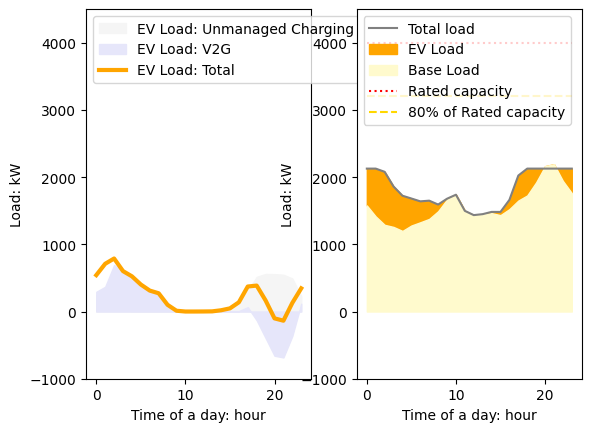

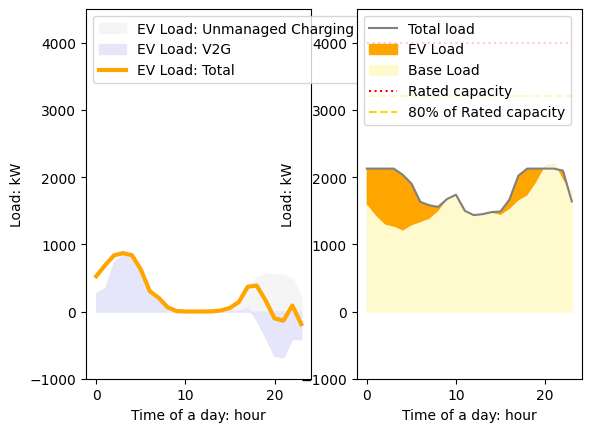

In [44]:
if __name__ == '__main__':
    # Define the inputs for vehicle to grid
    useCase = 1  # 1:residential, 2:office, 3: public, 4: others(user defined)

    # Initiate the number of vehicles and enrollment of vehicles in V1G
    n_vehicles = np.int_(800)
    percentV2G = 0.2
    percentFast = 0  # Out of vehicles using unmanaged charging
    n_V2G_Veh = np.int_(np.round(n_vehicles * percentV2G))
    n_V0G_Veh = np.int_(np.round(n_vehicles * (1 - percentV2G)))
    if useCase == 3 or useCase == 4:
        percentFast = 1
    n_fastVeh = np.int_(np.round(n_V0G_Veh * percentFast))
    n_slowVeh = np.int_(np.round(n_V0G_Veh * (1 - percentFast)))
    if useCase == 1 or useCase == 2:
        if n_fastVeh > 0:
            n_fastVeh = np.int_(np.round(n_fastVeh * 0.8))

    # EV's technical specifications
    batteryCapacity = 45
    batteryRange = 300

    # V2G charging power range
    nslow_Chargers = 80  # Number of level 1 chargers
    nfast_Chargers = 0  # Number of level 2 and DCF chargers
    power_managed_Uppper = 7
    power_managed_Lower = 3
    power_V2G_Upper = -3
    power_V2G_Lower = -7
    power_Slow = 7
    power_Fast = 20


    hourly_tariffs = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4]  # Example tariffs
    demand_charge_rate = 10  # Example demand charge rate

    charge_efficiency = 0.9
    discharge_efficiency = 0.9

    Charge_frequency = 1
    end_SOC = 2  # 2 is to charge fully
    transformer_capacity = 4000
    maxEfficiency = 0.8

    if useCase == 1 or useCase == 2:
        parking_Duration = [9.8, 9, 9.3, 8.8, 8.5, 7.3, 7.4, 7.7, 6.8, 5.4, 5, 5.2, 5.1, 5.2, 5, 6.1, 7.2, 9.1, 9.8, 9.8, 10.7, 9.4, 10.1, 8.8]
    if useCase == 3 or useCase == 4:
        parking_Duration = np.zeros(24)
        parking_Duration = parking_Duration + 4

    # Transformers' status
    if useCase == 1:
        base_Load = [1578.7, 1414.7, 1290.1, 1258.6, 1199.2, 1279.8, 1327.9, 1378, 1492.4, 1666.8, 1738.2, 1497.9, 1433.9,
                     1446.8, 1463.8, 1434.5, 1523.9, 1651.1, 1727.2, 1922, 2162.6, 2192.6, 1944.4, 1762.9]
    if useCase == 2:
        base_Load = [1043.071385, 1009.268146, 980.293941, 985.1229752, 973.0503897, 1011.682663, 1294.181163, 1675.674865, 2087.350029, 2290.169466, 2391.579184, 2125.982303, 2237.050089, 1812.095081, 1746.903119, 1733.623275, 1717.928914, 1800.022495, 1558.570785, 1302.631973, 1154.139172, 981.5011995, 874.0551888, 802.8269344]

    # Unmanaged model
    n_iter = 25
    Maxtime_Interval = 1440
    slow_Load_1h_avg = np.zeros(24)
    fast_Load_1h_avg = np.zeros(24)
    Unmanaged_charge()
    unmanaged_Load = np.zeros(24)
    unmanaged_Load = slow_Load_1h_avg + fast_Load_1h_avg

    # Initiate V1G vehicles' states
    v2g_startingTime, v2g_endingTime, v2g_startingSOC = initiate_V2G(n_V2G_Veh)

    # Optimize EV charging profiles (original and new optimizations)
    chargeprofiles_original, dischargeprofiles_original, total_load_original = V2G_optimization()
    chargeprofiles_new, dischargeprofiles_new, total_load_new = V2G_multi_objective_optimization_with_solar()

    # Perform total load analysis for both optimizations
    EV_load_original = loadAnalysis(chargeprofiles_original, dischargeprofiles_original, total_load_original)
    EV_load_new = loadAnalysis(chargeprofiles_new, dischargeprofiles_new, total_load_new)

    # Write results to Excel
    writeExcel(EV_load_original, total_load_original, sheet_name='aa')
    writeExcel(EV_load_new, total_load_new, sheet_name='bb')

    # Plot comparison
    plot_comparison(EV_load_original, EV_load_new, total_load_original, total_load_new, hourly_tariffs, transformer_capacity)
